In [1]:
import os
import numpy as  np
import pylab as plt
import pandas as pd
import csv
from scipy.signal import medfilt, butter, filtfilt, resample
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize
from data_import_v2 import import_ppd, preprocess_data, crop_signal, double_exponential, fit_curve_to_signal
from entities_v2 import GCaMPData ,LimbData, Frame, Clip, Experiment
from Utils import generate_custom_header, read_csv_in_chunks
import re
from datetime import datetime
import pickle
import IPython

In [ ]:
#load ppd file
mouse_id = "M501"
data_folder = fr'Z:\UriMons\Fiber Photometry\adBNST_eEPA_GCaMP8s\3rd_batch\Processed_Data\{mouse_id}'
ppd_filename = 'M501-2025-11-02-105809.ppd'
ppd_file_path = os.path.join(data_folder, ppd_filename)
photometry_data = import_ppd(ppd_file_path)

# ## load dlc annotations
# csv_filename = "M329_Cam2_30600-39600fDLC_resnet50_FPJun2shuffle1_500000_filtered.csv"
# csv_file_path = os.path.join(data_folder, csv_filename)

# #load dlc annotations, csv file
# dlc_csv_filename = "M329_Cam2_30600-39600fDLC_resnet50_FPJun2shuffle1_500000_filtered.csv"
# dlc_data_folder = fr'Z:\UriMons\Freezing_testing\DLC'
# dlc_csv_file_path = os.path.join(dlc_data_folder, dlc_csv_filename)
# freezing_data = pd.read_csv(dlc_csv_file_path)

# Load the Grooming bouts CSV file
grooming_bout_csv_filename = f"{mouse_id}_Grooming.csv"
grooming_bout_csv_path = os.path.join(data_folder, grooming_bout_csv_filename)
grooming_data = pd.read_csv(grooming_bout_csv_path)
grooming_data = grooming_data.dropna(subset=['Starting frame', 'Ending frame'])
grooming_data =  [(int(row[1]), int(row[2])) for row in grooming_data.itertuples(index=False, name=None)]

# Load the headipping CSV file
headipping_bout_csv_filename = f"{mouse_id}_HD.csv"
headipping_bout_csv_path = os.path.join(data_folder, headipping_bout_csv_filename)
if os.path.exists(headipping_bout_csv_path):
    headipping_data = pd.read_csv(headipping_bout_csv_path)
    headipping_data = headipping_data.dropna(subset=['Starting frame', 'Ending frame'])
    headipping_data =  [(int(row[1]), int(row[2])) for row in headipping_data.itertuples(index=False, name=None)]
else:
    headipping_data = None

# # Load the eating Bamba CSV file
# bamba_bout_csv_filename = "M324_Bamba.csv"
# bamba_bout_csv_path = os.path.join(data_folder, bamba_bout_csv_filename)
# bamba_data = pd.read_csv(bamba_bout_csv_path)
# bamba_data = bamba_data.dropna(subset=['Starting frame', 'Ending frame'])
# bamba_data =  [(int(row[1]), int(row[2])) for row in bamba_data.itertuples(index=False, name=None)]

# Load the Experiment index
index_filename_csv = f"{mouse_id}_index.csv"
index_filename_path = os.path.join(data_folder, index_filename_csv)
index_data= pd.read_csv(index_filename_path)
# Convert the single-row DataFrame to a Series
index_data = index_data.squeeze() if len(index_data) == 1 else index_data
index_data

In [3]:
# id and date extraction 
# Regex to extract mouse ID and date
pattern = r"(?P<mouse_id>M\d+)-(?P<date>\d{4}-\d{2}-\d{2})"

# Search for the pattern in the filename
match = re.search(pattern, ppd_filename)

if match:
    mouse_id = match.group('mouse_id')
    date_str = match.group('date')
    
    # Convert the date string to a datetime object
    date = datetime.strptime(date_str, '%Y-%m-%d')
else:
    raise ValueError("no match found")



Start photometry preprocess

In [4]:
## preprocess pypho data 
# sampling rate, starting point, ending point, if there is or isn't a third signal
CROP_FROM_START = 5  # in seconds
CROP_FROM_END = 1
photometry_sampling_rate = photometry_data['sampling_rate']
cropped_photometry_data = crop_signal(photometry_data,photometry_sampling_rate, CROP_FROM_START, CROP_FROM_END)

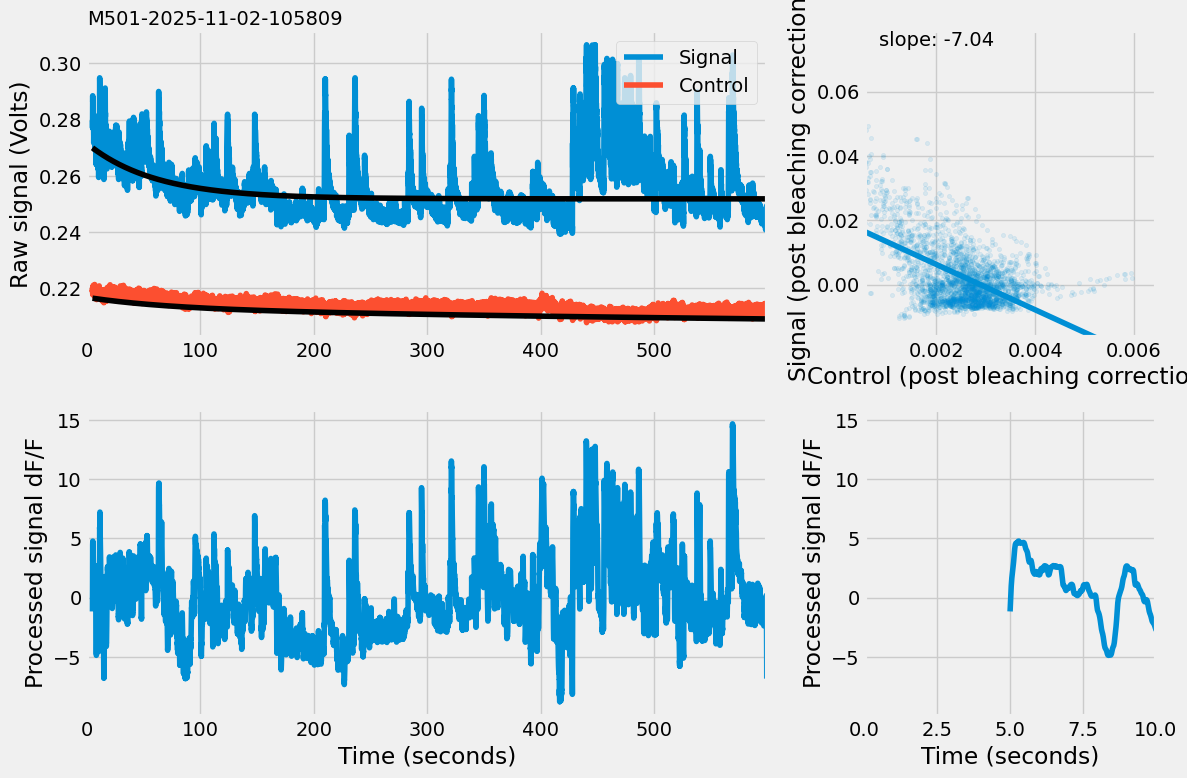

In [5]:
plt.rcParams['figure.figsize'] = [14, 12] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.
plt.style.use('fivethirtyeight')
preprocess_data(cropped_photometry_data,plot=True,median_filter=31)  # 1st & 2nd channels 
plt.show()
if 'analog_3' in cropped_photometry_data:
    preprocess_data(cropped_photometry_data,plot=True,control = 'analog_3',median_filter=31) # 1st & 3rd channels (ISO)
    plt.show()

In [6]:
# Extracting variables from ppd
GCaMP_raw = cropped_photometry_data['analog_1']
Isosbestic_raw = cropped_photometry_data['analog_2'] #Main control signal
#TdTom_raw = cropped_photometry_data['analog_3']   #Secondary control signal (if exist)
time_seconds = cropped_photometry_data['time']/1000
# digital signals
dig1 = cropped_photometry_data['digital_1']
dig2 = cropped_photometry_data['digital_2']

If the sample rate is not 50hz - here you can change it

In [7]:
# # If the sample rate is not 50hz - here you can change it
# # Original arrays
# data = GCaMP_raw  # sampled at 130 Hz
# time = time_seconds # corresponding time stamps

# old_rate = 130
# new_rate = 50

# # Compute the new length using rounding
# new_length = int(round(len(data) * new_rate / old_rate))

# # Generate indices by rounding values from np.linspace
# indices = np.round(np.linspace(0, len(data) - 1, new_length)).astype(int)

# GCaMP_raw = GCaMP_raw[indices]
# Isosbestic_raw = Isosbestic_raw[indices]
# time_seconds = time_seconds[indices]
# photometry_sampling_rate = new_rate


Back to Preprocessing

In [8]:
#Denoising
# Median filtering to remove electrical artifact.
GCaMP_denoised = medfilt(GCaMP_raw, kernel_size=31)
Isosbestic_denoised = medfilt(Isosbestic_raw, kernel_size=31)

# Lowpass filter - zero phase filtering (with filtfilt) is used to avoid distorting the signal.
b,a = butter(2, 20, btype='low', fs=photometry_sampling_rate)
GCaMP_denoised = filtfilt(b,a, GCaMP_denoised)
Isosbestic_denoised = filtfilt(b,a, Isosbestic_denoised)

# Photobleaching correction
b,a = butter(2, 0.001, btype='high', fs=photometry_sampling_rate)
GCaMP_highpass = filtfilt(b,a, GCaMP_denoised, padtype='even')
Isosbestic_highpass = filtfilt(b,a, Isosbestic_denoised, padtype='even')

##fit_curve_create_double_exp_point
GCaMP_expfit = fit_curve_to_signal(GCaMP_denoised,time_seconds)
Isosbestic_expfit = fit_curve_to_signal(Isosbestic_denoised,time_seconds)

# Subtract the exponential fits from the signals.
GCaMP_detrended = GCaMP_denoised - GCaMP_expfit
Isosbestic_detrended = Isosbestic_denoised - Isosbestic_expfit

# Motion correction
slope, intercept, r_value, p_value, std_err = linregress(x=Isosbestic_detrended, y=GCaMP_detrended)

# Subtracting estimated motion component of GCaMP to get motion corrected signal
GCaMP_est_motion = intercept + slope * Isosbestic_detrended
GCaMP_corrected = GCaMP_detrended - GCaMP_est_motion

# dF_F calculation
GCaMP_dF_F = 100*GCaMP_corrected/GCaMP_expfit

#Z-score calculation
GCaMP_zscored = (GCaMP_corrected-np.mean(GCaMP_corrected))/np.std(GCaMP_corrected)


In [9]:
def apply_percentile_threshold(data, percentile_threshold):
    """
    Adjusts the data so that only `percentile_threshold` percent of the values are below zero.
    
    Parameters:
        data (np.array): The input data to be adjusted.
        percentile_threshold (float): The desired percentage (0-100) of values allowed below zero.
    
    Returns:
        np.array: Adjusted data with the specified threshold applied.
    """
    # Compute the percentile threshold value
    threshold_value = np.percentile(data, percentile_threshold)
    
    # Determine the shift needed to satisfy the threshold condition
    shift_value = -threshold_value if threshold_value < 0 else 0
    
    # Apply the shift
    adjusted_data = data + shift_value

    return adjusted_data

# Example usage:
percentile_threshold = 25  # Change this to your desired threshold

GCaMP_dF_F_adjusted = apply_percentile_threshold(GCaMP_dF_F, percentile_threshold)
GCaMP_zscored_adjusted = apply_percentile_threshold(GCaMP_zscored, percentile_threshold)


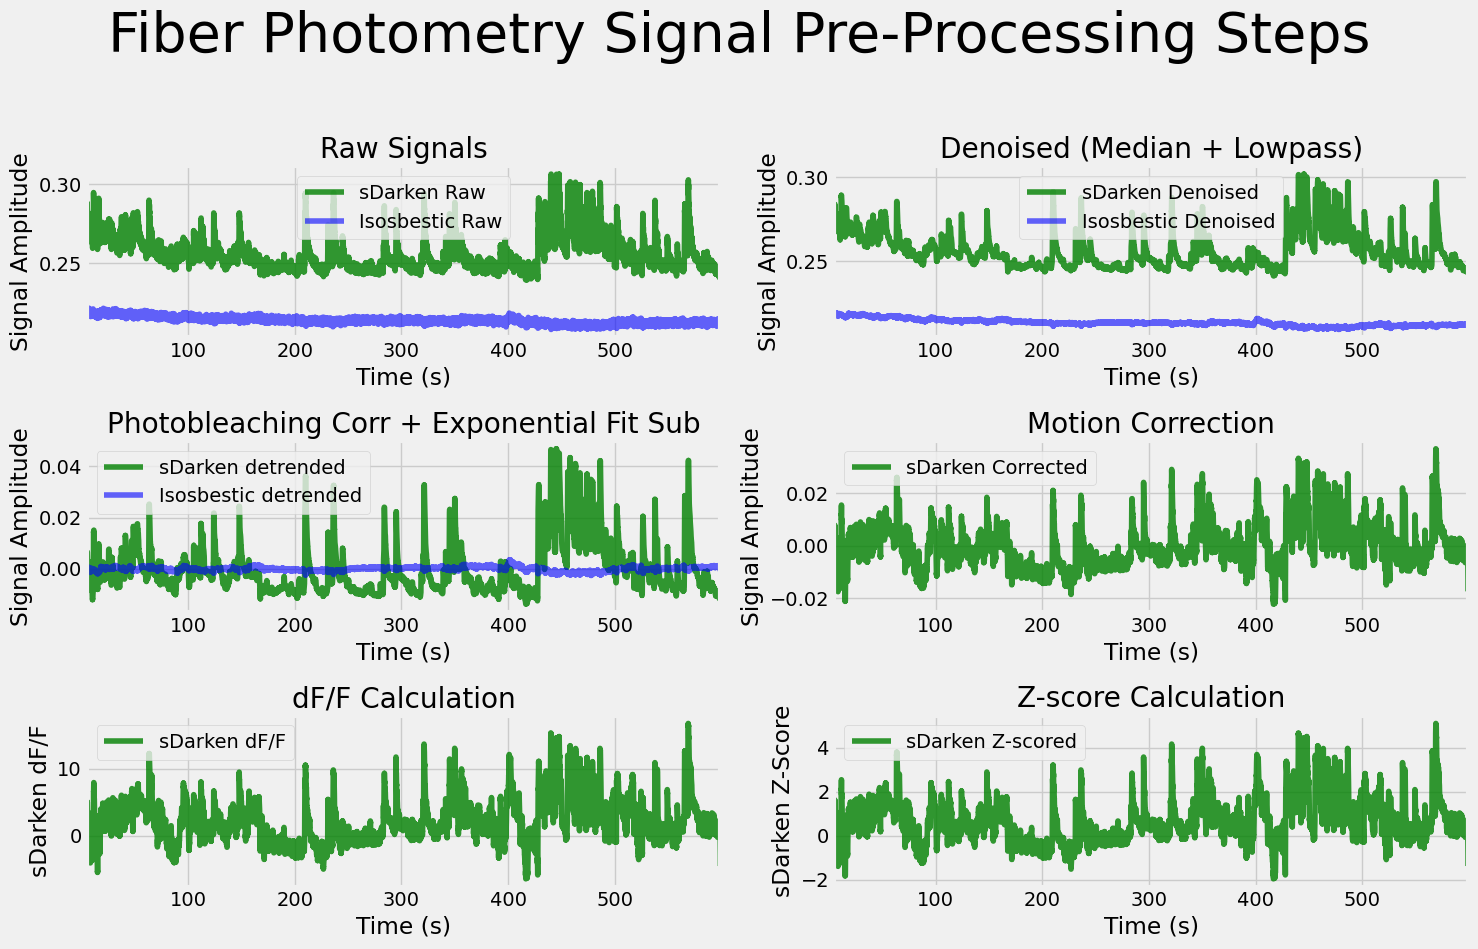

In [10]:
# Plotting
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle("Fiber Photometry Signal Pre-Processing Steps", fontsize=40)

# Define colors
GCaMP_color = 'green'
Isosbestic_color = 'blue'

# Plot each step with alpha for lighter traces
axs[0, 0].plot(time_seconds, GCaMP_raw, label='sDarken Raw', color=GCaMP_color, alpha=0.8)
axs[0, 0].plot(time_seconds, Isosbestic_raw, label='Isosbestic Raw', color=Isosbestic_color, alpha=0.6)
axs[0, 0].set_title("Raw Signals")
axs[0, 0].legend()

axs[0, 1].plot(time_seconds, GCaMP_denoised, label='sDarken Denoised', color=GCaMP_color, alpha=0.8)
axs[0, 1].plot(time_seconds, Isosbestic_denoised, label='Isosbestic Denoised', color=Isosbestic_color, alpha=0.6)
axs[0, 1].set_title("Denoised (Median + Lowpass)")
axs[0, 1].legend()

axs[1, 0].plot(time_seconds, GCaMP_detrended, label='sDarken detrended', color=GCaMP_color, alpha=0.8)
axs[1, 0].plot(time_seconds, Isosbestic_detrended, label='Isosbestic detrended', color=Isosbestic_color, alpha=0.6)
axs[1, 0].set_title("Photobleaching Corr + Exponential Fit Sub")
axs[1, 0].legend()

axs[1, 1].plot(time_seconds, GCaMP_corrected, label='sDarken Corrected', color=GCaMP_color, alpha=0.8)
axs[1, 1].set_title("Motion Correction")
axs[1, 1].legend()

axs[2, 0].plot(time_seconds, GCaMP_dF_F_adjusted, label='sDarken dF/F', color=GCaMP_color, alpha=0.8)
axs[2, 0].set_title("dF/F Calculation")
axs[2, 0].set_ylabel("sDarken dF/F")
axs[2, 0].legend()

axs[2, 1].plot(time_seconds, GCaMP_zscored_adjusted, label='sDarken Z-scored', color=GCaMP_color, alpha=0.8)
axs[2, 1].set_title("Z-score Calculation")
axs[2, 1].set_ylabel("sDarken Z-Score")
axs[2, 1].legend()

# Add generic axis labels for other subplots
for ax in axs.flat:
    ax.set_xlabel("Time (s)")
    if ax != axs[2, 0] and ax != axs[2, 1]:
        ax.set_ylabel("Signal Amplitude")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
gCamp_data = GCaMPData(GCaMP_raw, Isosbestic_raw, GCaMP_dF_F_adjusted, time_seconds, GCaMP_zscored_adjusted, photometry_sampling_rate)

In [12]:
# ## preprocess Dlc Data
# limb_prefixes = ['LED_ON', 'LED_OFF','R_corner', 'L_corner', 'Fiber_base', 'Fiber_connect', 'Nose', 'R_eye', 'L_eye', 'R_ear', 'L_ear', 'R_forepaw','L_forepaw', 'Body_center', 'R_hindpaw', 'L_hindpaw', 'Tail_base', 'Tail_mid', 'Tail_end']  # Add more prefixes as needed
# all_limbs_data = {prefix: [] for prefix in limb_prefixes}

# chunk_iter = read_csv_in_chunks(dlc_csv_file_path, chunksize=1000)
# frames = []

# for chunk in chunk_iter:
#     # Process each chunk (for example, print it)
#     for index, row in chunk.iterrows():
#         limbs = []
#         for prefix in limb_prefixes:
#             try:
#                 # Extract the relevant data for the current limb
#                 x = float(row[f'{prefix}_x'])
#                 y = float(row[f'{prefix}_y'])
#                 prob = float(row[f'{prefix}_likelihood'])
                
#                 # Create a LimbData object
#                 limb_data = LimbData(x, y, prob, prefix)
#                 limbs.append(limb_data)
#             except Exception as e:
#                 print(f"Unexpected error at row {index} for {prefix}: {e}")

#         frame = Frame(limbs, frame_number=index)
#         frames.append(frame)
# clip = Clip(frames)

# freezing_annotations =clip.detect_freezing(["R_eye"], (00,36000), 5, 10, 45)  # choose: limb_names, frame_range, tolerance_mm, max_tolerance_mm, min_frames

In [13]:
# exp = Experiment(gCamp_data, Clip([]), mouse_id, index_data['Genotype'], index_data['Sex'],index_data['DoB'], index_data['Constract'], index_data['ROI'], index_data['Paradigm'], grooming_data, headipping_annotations= headipping_data, freezing_annotations= freezing_annotations)
exp = Experiment(gCamp_data, Clip([]), mouse_id, index_data['Genotype'], index_data['Sex'],index_data['DoB'], index_data['Constract'], index_data['ROI'], index_data['Paradigm'], grooming_data, headipping_annotations= headipping_data)
preproced_data_file_name = f'{exp.Mouse_id}_{exp.paradigm}_{exp.Region_of_interest}'
preproced_data_file_path =  os.path.join(data_folder, preproced_data_file_name)

NameError: name 'index_data' is not defined

In [ ]:

with open(f'{preproced_data_file_path}.pkl', 'wb') as f:
    pickle.dump(exp, f)

In [ ]:
exp.Grooming_annotations

[(423, 821),
 (872, 939),
 (4247, 4452),
 (4594, 4948),
 (5037, 5230),
 (8860, 8881),
 (8897, 8916),
 (8955, 9005),
 (9056, 9221),
 (9247, 9783),
 (16337, 16343),
 (37688, 38207),
 (43407, 43966),
 (44085, 44869),
 (44903, 44929),
 (47151, 47163),
 (48724, 48818),
 (50373, 50388),
 (52060, 52087),
 (58545, 58550),
 (61257, 62686),
 (62748, 63823),
 (63976, 63991),
 (75936, 75960),
 (79392, 79422),
 (82583, 82614),
 (85832, 85851),
 (88862, 88897)]

In [ ]:
exp.Headipping_annotations

[(18174, 18191),
 (18238, 18260),
 (18311, 18336),
 (18336, 18367),
 (18500, 18620),
 (18705, 18726),
 (18733, 18815),
 (18841, 18862),
 (18898, 18912),
 (19190, 19200),
 (19319, 19341),
 (19527, 19560),
 (19652, 19684),
 (19731, 19756),
 (20286, 20295),
 (20825, 20862),
 (20884, 21030),
 (21116, 21147),
 (21191, 21213),
 (21263, 21302),
 (21348, 21366),
 (21385, 21418),
 (21534, 21574),
 (21654, 21702),
 (23439, 23505),
 (23541, 23572),
 (23865, 23884),
 (23934, 23961),
 (24069, 24083),
 (24186, 24202),
 (26225, 26269),
 (26413, 26438),
 (27180, 27274),
 (30091, 30104),
 (30255, 30337),
 (30845, 30871),
 (30933, 30980),
 (31023, 31075),
 (32118, 32153),
 (32749, 32762),
 (34000, 34046),
 (34314, 34355),
 (34365, 34421),
 (34593, 34635),
 (34716, 34849),
 (35095, 35116)]

In [ ]:
exp.Freezing_annotations